# Module 8 - Programming Assignment

## Directions

1. Change the name of this file to be your JHED id as in `jsmith299.ipynb`. Because sure you use your JHED ID (it's made out of your name and not your student id which is just letters and numbers).
2. Make sure the notebook you submit is cleanly and fully executed. I do not grade unexecuted notebooks.
3. Submit your notebook back in Blackboard where you downloaded this file.

*Provide the output **exactly** as requested*

In [1]:
from copy import deepcopy

## Decision Trees

For this assignment you will be implementing and evaluating a Decision Tree using the ID3 Algorithm (**no** pruning or normalized information gain). Use the provided pseudocode. The data is located at (copy link):

http://archive.ics.uci.edu/ml/datasets/Mushroom

**Just in case** the UCI repository is down, which happens from time to time, I have included the data and name files on Blackboard.

<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <strong>Important</strong>
    <p>
        No Pandas. The only acceptable libraries in this class are those contained in the `environment.yml`. No OOP, either. You can used Dicts, NamedTuples, etc. as your abstract data type (ADT) for the the tree and nodes.
    </p>
</div>

One of the things we did not talk about in the lectures was how to deal with missing values. There are two aspects of the problem here. What do we do with missing values in the training data? What do we do with missing values when doing classifcation?

For the first problem, C4.5 handled missing values in an interesting way. Suppose we have identifed some attribute *B* with values {b1, b2, b3} as the best current attribute. Furthermore, assume there are 5 observations with B=?, that is, we don't know the attribute value. In C4.5, those 5 observations would be added to *all* of the subsets created by B=b1, B=b2, B=b3 with decreased weights. Note that the observations with missing values are not part of the information gain calculation.

This doesn't quite help us if we have missing values when we use the model. What happens if we have missing values during classification? One approach is to prepare for this advance. When you train the tree, you need to add an implicit attribute value "?" at every split. For example, if the attribute was "size" then the domain would be ["small", "medium", "large", "?"]. The "?" value gets all the data (because ? is now a wildcard). However, there is an issue with this approach. "?" becomes the worst possible attribut value because it has no classification value. What to do? There are several options:

1. Never recurse on "?" if you do not also recurse on at least one *real* attribute value.
2. Limit the depth of the tree.

There are good reasons, in general, to limit the depth of a decision tree because they tend to overfit.
Otherwise, the algorithm *will* exhaust all the attributes trying to fulfill one of the base cases.

You must implement the following functions:

`train` takes training_data and returns the Decision Tree as a data structure. There are many options including namedtuples and just plain old nested dictionaries. **No OOP**.

```
def train(training_data, depth_limit=None):
   # returns the Decision Tree.
```

The `depth_limit` value defaults to None. (What technique would we use to determine the best parameter value for `depth_limit` hint: Module 3!)

`classify` takes a tree produced from the function above and applies it to labeled data (like the test set) or unlabeled data (like some new data).

```
def classify(tree, observations, labeled=True):
    # returns a list of classifications
```

`evaluate` takes a data set with labels (like the training set or test set) and the classification result and calculates the classification error rate:

$$error\_rate=\frac{errors}{n}$$

Do not use anything else as evaluation metric or the submission will be deemed incomplete, ie, an "F". (Hint: accuracy rate is not the error rate!).

`cross_validate` takes the data and uses 10 fold cross validation (from Module 3!) to `train`, `classify`, and `evaluate`. **Remember to shuffle your data before you create your folds**. I leave the exact signature of `cross_validate` to you but you should write it so that you can use it with *any* `classify` function of the same form (using higher order functions and partial application).

Following Module 3's discussion, `cross_validate` should print out the fold number and the evaluation metric (error rate) for each fold and then the average value (and the variance). What you are looking for here is a consistent evaluation metric cross the folds. You should print the error rates in terms of percents (ie, multiply the error rate by 100 and add "%" to the end).

```
def pretty_print_tree(tree):
    # pretty prints the tree
```

This should be a text representation of a decision tree trained on the entire data set (no train/test).

To summarize...

Apply the Decision Tree algorithm to the Mushroom data set using 10 fold cross validation and the error rate as the evaluation metric. When you are done, apply the Decision Tree algorithm to the entire data set and print out the resulting tree.

**Note** Because this assignment has a natural recursive implementation, you should consider using `deepcopy` at the appropriate places.

-----

In [2]:
from math import log2
from copy import deepcopy
from random import shuffle
from typing import List, Dict, Tuple, Callable
import matplotlib.pyplot as plt

### Importing functions from Module 3
The following modules from module three aid in the retrieval, fold creation, and train and test data splitting. The functions `mean()` and `variance()` compute the corresponding mean and variances of a list of floating values.

In [3]:
def parse_data(file_name: str, shuffle_ = False) -> []:
    data = []
    file = open(file_name, "r", encoding='utf-8-sig')
    for line in file:
        datum = [value for value in line.rstrip().split(",")]
        data.append(datum)
    if shuffle_:
        shuffle(data)
    return data

def create_folds(xs: List, n: int) -> List[List[List]]:
    k, m = divmod(len(xs), n)
    # be careful of generators...
    return list(xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

def create_train_test(folds: List[List[List]], index: int) -> Tuple[List[List], List[List]]:
    training = []
    test = []
    for i, fold in enumerate(folds):
        if i == index:
            test = fold
        else:
            training = training + fold
    return training, test

def mean(list_: list) -> float:
    mean_value = sum([val for val in list_])/len(list_)
    return mean_value

def variance(values: list):
    mean_value = mean(values)
    variance = sum([(val-mean_value)**2 for val in values])/(len(values)-1)
    return variance

In order to illustrate the proper execution of the functions, I will use the data set provided for the self-check for the assertions of every function and also before doing the cross-validation on the final mushroom dataset.

In [4]:
data = parse_data('SelfCheckData.csv')

In [5]:
data

[['round', 'large', 'blue', 'no'],
 ['square', 'large', 'green', 'yes'],
 ['square', 'small', 'red', 'no'],
 ['round', 'large', 'red', 'yes'],
 ['square', 'small', 'blue', 'no'],
 ['round', 'small', 'blue', 'no'],
 ['round', 'small', 'red', 'yes'],
 ['square', 'small', 'green', 'no'],
 ['round', 'large', 'green', 'yes'],
 ['square', 'large', 'green', 'yes'],
 ['square', 'large', 'red', 'no'],
 ['square', 'large', 'green', 'yes'],
 ['round', 'large', 'red', 'yes'],
 ['square', 'small', 'red', 'no'],
 ['round', 'small', 'green', 'no']]

### Helper functions to the ID3 algorithm
The ID3 algorithm implemented below uses a number of functions. I will now document each function as well as create assertions on them based on the data set provided in this module's self-check.

#### total_entropy(data, target_variable)
`total_entropy(data, target_variable)` computes the total entropy of the `target_variable` on the data. It returns a float that corresponds to the following formula:
$$
E[S] = - \sum_i p_i \log_2(p_i)
$$
The function returns a tuple of values to be used further down in the ID3 algorithm. The tuple contains `total_entropy` which corresponds to the value of the total entropy for the target variable, the `unique_target_labels`, the total number of `n` observations in the dataset, and finally a dictionary of the `label_count` for all the labels in the target variable,

In [6]:
def total_entropy(data, target_variable):
    unique_target_labels = []
    label_count = {}
    n = 0
    for row in data:
        if row[target_variable] not in unique_target_labels:
            unique_target_labels.append(row[target_variable])
            label_count[row[target_variable]] = 1
        else:
            label_count[row[target_variable]] += 1
        n += 1
    total_entropy = 0
    for label in unique_target_labels:
        total_entropy += -label_count[label]/n * log2(label_count[label]/n)
    
    return total_entropy, unique_target_labels, n, label_count

In [7]:
t_entropy, unique_target_labels, n, label_count = total_entropy(data, 3)
assert t_entropy == 0.9967916319816366
assert unique_target_labels == ['no', 'yes']
assert n == 15
assert label_count == {'no': 8, 'yes': 7}

#### `variable_entropy(data, variable, target_variable, unique_target_labels, n)`
This function computes a particular variable's entropy. It takes as arguments the dataset `data`, the index location of the `variable`, the index location of the `target_variable`, the `unique_target_labels` from the `total_entropy()` function, and also the value of `n` from the `total_entropy()` function.
The function returns a list which includes the index value of the `variable` in the dataset, the `unique_labels` corresponding to that `variable` and the `entropy` value for that `variable`.

In [8]:
def variable_entropy(data, variable, target_variable, unique_target_labels, n):
    unique_labels = []
    label_count = {}
    for row in data:
        if row[variable] not in unique_labels:
            unique_labels.append(row[variable])
            label_count[row[variable]] = {}
            label_count[row[variable]]['target_counts'] = {}
            label_count[row[variable]]['target_n'] = 0
            for target_label in unique_target_labels:
                label_count[row[variable]]['target_counts'][target_label] = 0
                if row[target_variable] == target_label:
                    label_count[row[variable]]['target_counts'][target_label] = 1
                    label_count[row[variable]]['target_n'] += 1
        else:
            for target_label in unique_target_labels:
                if row[target_variable] == target_label:
                    label_count[row[variable]]['target_counts'][target_label] += 1
                    label_count[row[variable]]['target_n'] += 1
    entropy = 0
    for label in unique_labels:
        label_count[label]['entropy'] = 0
        for target_label in label_count[label]['target_counts']:
            if label_count[label]['target_counts'][target_label] > 0:
                fraction = label_count[label]['target_counts'][target_label]/label_count[label]['target_n']
                label_count[label]['entropy'] += -fraction*log2(fraction)
        entropy += label_count[label]['target_n']/n*label_count[label]['entropy']
    return [variable, unique_labels, entropy]

In [9]:
entropies = [[0, ['round', 'square'], 0.9688045983759654],
             [1, ['large', 'small'], 0.7087956297166236],
             [2, ['blue', 'green', 'red'], 0.7673183336217959]]
for variable in range(len(entropies)):
    assert variable_entropy(data, variable, 3, unique_target_labels, n) == entropies[variable]

#### pick_best_attribute(data, target_variable)
Combines the results from `total_entropy(data, target_variable)` and `variable_entropy(data, atr, target_variable, unique_target_labels, n)` to build a sorted list of all the attributes. The list is sorted by their information gain. The information gain is given by the formula:
$$
G(S,A) = E(S) - \sum_{v \forall V_A} \frac{|S_v|}{|S|} E(S_v)
$$
The function returns the attribute with the best information gain value.

In [10]:
def pick_best_attribute(data, target_variable):
    t_entropy, unique_target_labels, n, label_count = total_entropy(data, target_variable)
    atributes = [atr for atr in range(len(data[0])) if atr != target_variable]
    inf_gain = []
    for atr in atributes:
        attr_entropy = variable_entropy(data, atr, target_variable, unique_target_labels, n)
        attr_entropy.append(t_entropy - attr_entropy[2])
        if len(inf_gain)==0:
            inf_gain.append(attr_entropy)        
        else:
            for i in range(len(inf_gain)):
                if attr_entropy[2] < inf_gain[i][2]:
                    inf_gain.insert(i, attr_entropy)
                    break
    return inf_gain[0]

In [11]:
assert pick_best_attribute(data, 3) == [1, ['large', 'small'], 0.7087956297166236, 0.287996002265013]

#### new_node(best_attribute)
Wrapper function which returns a dictionary with the components 'node' of the index value of the best attribute, and 'children' as the distinct labels of the best attribute.

In [12]:
def new_node(best_attribute):
    node = {'node':best_attribute[0], 'children':best_attribute[1]}
    return node

In [13]:
best_attribute = pick_best_attribute(data, 3)
assert new_node(best_attribute) == {'node': 1, 'children': ['large', 'small']}

#### majority_label(label_count)
The function `majority_label(label_count)` provides the mode label given a `label_count`. It produces the label with the highest frequency.

In [14]:
def majority_label(label_count):
    labels = list(label_count.keys())
    temp_majority = labels[0],label_count[labels[0]]
    for label in labels[1:]:
        comp_label = label,label_count[label]
        if comp_label[1]>temp_majority[1]:
            temp_majority = comp_label
    return temp_majority[0]    

In [15]:
assert majority_label(label_count) == 'no'

#### is_homogeneous(label_count, n)
`is_homogeneous(label_count, n)` returns the `label` when the frequency of a particular label equals the total number of observations given the `label_count`. Otherwise it returns `False`.

In [16]:
def is_homogeneous(label_count, n):
    for label in label_count:
        if label_count[label] == n:
            return label
    return False

In [17]:
assert is_homogeneous({'red':5},5) == 'red'
assert is_homogeneous({'red':4},5) == False

#### subset(data, attribute, label)
Creates and returns a `subset_data` dataset  for `data` where `attribute` equals `label`.

In [18]:
def subset(data, attribute, label):
    subset_data = []
    for row in data:
        if row[attribute] == label:
            subset_data.append(deepcopy(row))
    return subset_data

In [19]:
assert subset(data, 1, 'large') == [['round', 'large', 'blue', 'no'],
                                    ['square', 'large', 'green', 'yes'],
                                    ['round', 'large', 'red', 'yes'],
                                    ['round', 'large', 'green', 'yes'],
                                    ['square', 'large', 'green', 'yes'],
                                    ['square', 'large', 'red', 'no'],
                                    ['square', 'large', 'green', 'yes'],
                                    ['round', 'large', 'red', 'yes']]

### ID3 algorithm
The ID3 algorithm belows implements the pseudo-code provided in the course, there are a couple of changes implemented, however; there is a max depth stop. the `max_depth` parameter indicates the early stop for the algorithm. Whenever the given iteration of the tree achieves a depth of `max_depth`, the function returns the majority label given by `majority_label`.

In [20]:
def id3(data, attributes, target_variable, default, level, max_depth = None):
    
    t_entropy, unique_target_labels, n, label_count = total_entropy(data, target_variable)
    m_label = majority_label(label_count)
    
    if len(data)==0: 
        return default
    label = is_homogeneous(label_count, n)
    if label: 
        return label
    if attributes is None or len(attributes)==0:
        return m_label
        
    if level == max_depth:
        return m_label
    
    level += 1
    best_attribute = pick_best_attribute(data, target_variable)
    node = new_node(best_attribute)
    
    
    default_label = m_label
    
    domain_best_attribute = best_attribute[1]
    for value in range(len(domain_best_attribute)):
        data_subset = subset(data, best_attribute[0], domain_best_attribute[value])
        new_attributes = [attr for attr in attributes if attr != best_attribute[0]]
        child = id3(data_subset, new_attributes, target_variable, default_label, level, max_depth)        
        parent= node['children']
        parent[value] = {'edge':domain_best_attribute[value],'children':child}
    
    return node    

In [21]:
node = id3(data, [0,1,2], 3, 'no', 0, 3)
assert node == {'node': 1,
 'children': [{'edge': 'large',
   'children': {'node': 2,
    'children': [{'edge': 'blue', 'children': 'no'},
     {'edge': 'green', 'children': 'yes'},
     {'edge': 'red',
      'children': {'node': 0,
       'children': [{'edge': 'round', 'children': 'yes'},
        {'edge': 'square', 'children': 'no'}]}}]}},
  {'edge': 'small',
   'children': {'node': 0,
    'children': [{'edge': 'square', 'children': 'no'},
     {'edge': 'round',
      'children': {'node': 2,
       'children': [{'edge': 'blue', 'children': 'no'},
        {'edge': 'red', 'children': 'yes'},
        {'edge': 'green', 'children': 'no'}]}}]}}]}
node2 = id3(data, [0,1,2], 3, 'no', 0, 1)
assert node2 == {'node': 1,
 'children': [{'edge': 'large', 'children': 'yes'},
  {'edge': 'small', 'children': 'no'}]}

#### replace_null(data_, target, null_marker)
This function is used to handle missing observations. It creates a frequency table and replaces all the missing values given by the `null_marker` while taking into account its corresponding target value. That is, it replaces in the training data the modal value of the missing value taking into account it's corresponding target value.

In [22]:
def replace_null(data_, target, null_marker):

    missing = []
    missing_attributes = []
    for row in range(len(data_)):
        for col in range(len(data_[row])):
            if data_[row][col] == null_marker:
                missing.append([row,col,data_[row][target]])
                if [col,data_[row][target]] not in missing_attributes:
                    missing_attributes.append([col,data_[row][target]])

    attr_frequencies = {}
    for attr in missing_attributes:
        for row in range(len(data_)):
            if data_[row][target] == attr[1] and data_[row][attr[0]] != null_marker:
                if attr[1] not in attr_frequencies.keys():
                    attr_frequencies[attr[1]] = []
                else:
                    attr_frequencies[attr[1]].append(data_[row][attr[0]])

    for attr in attr_frequencies:
        temp_dict = {}
        temp_frequencies = []
        for val in attr_frequencies[attr]:        
            if val not in temp_dict:
                temp_dict[val] = 1
            else:
                temp_dict[val] += 1
        for k in temp_dict:
            temp_frequencies.append([k, temp_dict[k]])
        temp_frequencies.sort(key= lambda x: x[1], reverse=True)
        attr_frequencies[attr] = temp_frequencies[0][0]

    for m in missing:
        data_[m[0]][m[1]] = attr_frequencies[m[2]]

#### `train(data, attributes, target_variable, default, max_depth = None, null_marker = '?')`
This functions brings all of the functions previously defined together by first doing preprocessing of the training data by `replace_null()` and then creates a tree.

In [23]:
def train(data, attributes, target_variable, default, max_depth = None, null_marker = '?'):
    replace_null(data, target_variable, null_marker)
    tree = id3(data, attributes, target_variable, default, 0, max_depth)
    return tree

In [24]:
# keeping max depth at 1
assert train(data, [0,1,2], 3, 'no', 1) == {'node': 1,
 'children': [{'edge': 'large', 'children': 'yes'},
  {'edge': 'small', 'children': 'no'}]}
# without capping the depth
assert train(data, [0,1,2], 3, 'no') == {'node': 1,
 'children': [{'edge': 'large',
   'children': {'node': 2,
    'children': [{'edge': 'blue', 'children': 'no'},
     {'edge': 'green', 'children': 'yes'},
     {'edge': 'red',
      'children': {'node': 0,
       'children': [{'edge': 'round', 'children': 'yes'},
        {'edge': 'square', 'children': 'no'}]}}]}},
  {'edge': 'small',
   'children': {'node': 0,
    'children': [{'edge': 'square', 'children': 'no'},
     {'edge': 'round',
      'children': {'node': 2,
       'children': [{'edge': 'blue', 'children': 'no'},
        {'edge': 'red', 'children': 'yes'},
        {'edge': 'green', 'children': 'no'}]}}]}}]}

#### classify(tree, observation)
Given a particular `observation`, the function `classify(tree, observation)` traverses the given `tree` and returns the classified value.

In [25]:
def classify(tree, observation):
    if isinstance(tree['children'], str):
        return tree['children']
    elif isinstance(tree['children'], dict):
        tree = tree['children']        
        return classify(tree, observation)        
    else:
        label = observation[tree['node']]
        correct_child = [child for child in range(len(tree['children'])) if tree['children'][child]['edge'] == label][0]
        tree = tree['children'][correct_child]
        return classify(tree, observation)

In [26]:
assert classify(node, ['round', 'large', 'red', 'yes']) == 'yes'
assert classify(node, ['square', 'small', 'red', 'no']) == 'no'

#### `evaluate(tree, evaluation_data, attributes, target_variable)`
This function uses `classify()` and the corresponding true values to compute the error rate provided the `tree` used for classification. The error is given by the specification of the problem above.

In [27]:
def evaluate(tree, evaluation_data, attributes, target_variable):
    evaluation_features = [[row[atr] for atr in attributes] for row in evaluation_data]
    evaluation_target = [row[target_variable] for row in evaluation_data]
    evluation_classification = [classify(tree, row) for row in evaluation_features]
    n = len(evaluation_target)
    error = sum([evaluation_target[i]!=evluation_classification[i] for i in range(n)])
    return error/n

In [28]:
assert evaluate(node, data, [0,1,2], 3) == 0.0

#### `pretty_print(tree, depth=0, attr_dict=None)`
This function prints a readable version of the dictionary based `tree`. If an `attr_dict` is passed it uses the actual name of each attribute, otherwise it uses the index value among all of the data attributes (target attribute excluded). 

In [29]:
def pretty_print(tree, depth=0, attr_dict=None):
    if isinstance(tree, str):
        
        print(depth*'\t',f"then {tree}")
    elif isinstance(tree, dict):
        if 'node' in tree.keys():
            print(depth*'\t',f"Consider {tree['node'] if attr_dict is None else attr_dict[tree['node']]}:")
            depth +=1
            tree = tree['children']
            pretty_print(tree, depth, attr_dict)
        else:
            print(depth*'\t',f"If {tree['edge']}:")
            depth +=1
            tree = tree['children']
            pretty_print(tree, depth, attr_dict)
    else:
        for i in range(len(tree)):
            pretty_print(tree[i], depth, attr_dict)
        

In [30]:
pretty_print(node, 0, {0:'Shape',1:'Size',2:'Color'})

 Consider Size:
	 If large:
		 Consider Color:
			 If blue:
				 then no
			 If green:
				 then yes
			 If red:
				 Consider Shape:
					 If round:
						 then yes
					 If square:
						 then no
	 If small:
		 Consider Shape:
			 If square:
				 then no
			 If round:
				 Consider Color:
					 If blue:
						 then no
					 If red:
						 then yes
					 If green:
						 then no


### Cross validation on mushroom data
The procedure below uses the functions defined above to implement 10 fold cross validation on the mushroom data set provided in the assignment. The base model used is simply choosing the label 'p' for all observations. A couple of important things to note are:
1. We do random shuffling in the `parse_data()` function,
2. We use `create_folds()` to create all ten folds,
3. We use `create_train_test()` to create the train and test data sets.

In [31]:
mushroom_data = parse_data('agaricus-lepiota.data', True)
fold_label = 'Fold'
knn_mse_label = 'Tree(%)'
base_mse_label = 'Base(%)'
mean_label = "Mean"
variance_label = 'Var.'

folds = create_folds(mushroom_data, 10)
base_errors = []
model_errors = []
tree = None
print('Error Rate by Fold: Tree Vs. Base')
print(f"""{fold_label : <5}{knn_mse_label : ^15}{base_mse_label : >10}""")
for i in range(len(folds)):
    training, test = create_train_test(folds, i)    
    y = [sample[0] for sample in test]       

    base_y_hat = ['p' for sample in test]
    base_error = sum([y[i] != base_y_hat[i] for i in range(len(test))])
    base_error_rate = base_error/len(test)
    base_errors.append(base_error_rate)

    tree = train(training, range(1,23), 0, 'e', 4)
    error_rate = evaluate(tree, test, range(1,23), 0)
    model_errors.append(error_rate)

    print(f"""{i+1 : <5}{error_rate*100 : ^15.2f}{base_error_rate*100 : >10.2f}""")

base_mean = mean(base_errors)
model_mean = mean(model_errors)
print(f"""{mean_label : <5}{model_mean*100 : ^15.2f}\
{base_mean*100 : >10.2f}""")

base_variance = variance([error*100 for error in base_errors])
model_variance = variance([error*100 for error in model_errors])

print(f"""{variance_label : <5}{model_variance : ^15.2f}\
{base_variance : >10.2f}""")   

Error Rate by Fold: Tree Vs. Base
Fold     Tree(%)       Base(%)
1         50.68          51.91
2         49.32          51.29
3         50.92          52.64
4         47.36          49.69
5         49.38          51.85
6         51.23          52.96
7         47.17          49.63
8         48.89          52.09
9         54.93          57.27
10        46.67          48.65
Mean      49.66          51.80
Var.      6.00            5.71


The results above indicate tha the average tree beats slightly the based model. Below is a graphical representation of the error rates in the tree based models and the base models.

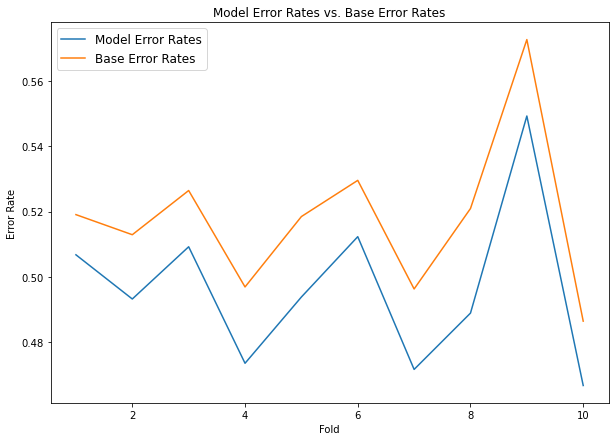

In [32]:
fig = plt.figure(figsize=(10, 7))
plt.plot(range(1,len(model_errors)+1),model_errors, label='Model Error Rates')
plt.plot(range(1,len(base_errors)+1),base_errors, label = 'Base Error Rates')
plt.xlabel("Fold")
plt.ylabel("Error Rate")
plt.legend(fontsize=12)
plt.title('Model Error Rates vs. Base Error Rates')
plt.show()

In [33]:
pretty_print(tree)

 Consider 5:
	 If f:
		 then p
	 If y:
		 then p
	 If s:
		 then p
	 If n:
		 Consider 20:
			 If n:
				 then e
			 If k:
				 then e
			 If w:
				 Consider 22:
					 If g:
						 then e
					 If w:
						 then e
					 If d:
						 Consider 8:
							 If n:
								 then p
							 If b:
								 then e
					 If p:
						 then e
					 If l:
						 Consider 3:
							 If n:
								 then e
							 If c:
								 then e
							 If w:
								 then p
							 If y:
								 then p
			 If r:
				 then p
			 If h:
				 then e
			 If y:
				 then e
			 If o:
				 then e
			 If b:
				 then e
	 If p:
		 then p
	 If l:
		 then e
	 If a:
		 then e
	 If c:
		 then p
	 If m:
		 then p


## Before You Submit...

1. Did you provide output exactly as requested?
2. Did you re-execute the entire notebook? ("Restart Kernel and Rull All Cells...")
3. If you did not complete the assignment or had difficulty please explain what gave you the most difficulty in the Markdown cell below.
4. Did you change the name of the file to `jhed_id.ipynb`?

Do not submit any other files.